## Notebook for generating and expanding the dataset

In [121]:
import numpy as np 
import cv2
from matplotlib import pyplot as plt
import os
import csv
import json
import random


DS_path = "/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train"
Generated_img_path = "/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train"
os.makedirs(f"{Generated_img_path}", exist_ok=True)

np.random.seed(100)

**Data format:**
{
      "image_id": "L1000793.jpeg",
      "width": 4000,
      "height": 3000,
      "annotations": [
        12 0.520617 0.203704 0.104938 0.166667
        10 0.682963 0.350926 0.096296 0.142593
        10 0.338518 0.734259 0.096296 0.135185
        6 0.373704 0.395370 0.070370 0.131481
        6 0.618765 0.662963 0.079012 0.137037
        7 0.478642 0.537963 0.102469 0.157407
      ]
    }

**Wanted transformations**

- Add noise (no change needed in bboxes)
- Rotations (needed change in bboxes)
- Translations (needed change in bboxes)
- Resizing (small) (change in bboxes)
- Slight color changes (no change in bboxes)
- Slight perspective warp ((needed chnage in bboxes))


### CREATING ONE JSON FILE with TXT files and csv file combined

In [122]:
# Paths
label_csv_path = "/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train.csv"
annotation_txt_dir = "/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/project/src"

# Initialize merged data
dataset = []

# Read CSV
csv_map = {}
with open(label_csv_path, "r") as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header
    for row in reader:
        image_id = row[0]
        class_counts = list(map(int, row[1:]))  # [2, 0, 0, ...]
        csv_map[image_id] = class_counts

# Loop through annotation txt files
for fname in os.listdir(annotation_txt_dir):
    if not fname.endswith(".txt"):
        continue

    image_id = fname.split(".")[0]  # e.g., "L1000756"
    txt_path = os.path.join(annotation_txt_dir, fname)

    # Read YOLO annotations
    boxes = []
    labels = []
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # skip malformed line
            cls, x_c, y_c, w, h = map(float, parts)
            boxes.append([x_c, y_c, w, h])
            labels.append(int(cls))

    # Get CSV label vector if available
    numeric_id = image_id[-7:]  # Get the 7-digit numeric part
    label_vector = csv_map.get(numeric_id, None)

    # Construct entry
    dataset.append({
        "image_id": image_id + ".JPG",  # Assuming image name is like "L1000756.JPG"
        "bboxes": boxes,
        "labels": labels,
        "label_vector": label_vector  # Optional — can remove if not needed
    })

# Save to JSON
with open("merged_annotations.json", "w") as f:
    json.dump(dataset, f, indent=2)

### Creating the IMG class

In [123]:
class AnnotatedImage:
    def __init__(self, image_path, bboxes, labels, width, height):
        """
        Args:
            image_path (str): Path to the image file.
            bboxes (List[List[int]]): List of bounding boxes in [x_min, y_min, x_max, y_max] format.
            labels (List[int]): List of class indices corresponding to the bboxes.
        """
        self.image_path = image_path
        self.bboxes = bboxes  # YOLO formaty
        self.labels = labels  # List of class indices
        self.width = width
        self.height = height

    def __repr__(self):
        filename = os.path.basename(self.image_path)
        box_str = ", ".join([f"{box}" for box in self.bboxes])
        return f"AnnotatedImage(file='{filename}', boxes=[{box_str}], labels = {self.labels})"
    
# test image in correct format
img = AnnotatedImage("L1000756.JPG",
                     [[0.520617,0.203704,0.104938,0.166667]],
                     [12],
                     6000,
                     4000
                     )

def create_annotated_images_from_json(json_path, ds_path1 = DS_path, ds_path2 = Generated_img_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    annotated_images = []
    for item in data:
        img_path = item["image_id"]

        # Try loading the image from both dataset paths
        full_path1 = os.path.join(ds_path1, img_path)
        full_path2 = os.path.join(ds_path2, img_path)

        if os.path.exists(full_path1):
            img = cv2.imread(full_path1)
        elif os.path.exists(full_path2):
            img = cv2.imread(full_path2)
        else:
            print(f"Warning: Image not found: {img_path}")
            continue

        if img is None:
            print(f"Warning: Failed to read image: {img_path}")
            continue

        height, width = img.shape[:2]

        img_a = AnnotatedImage(
            image_path=img_path,
            bboxes=item["bboxes"],
            labels=item["labels"],
            width=width,
            height=height
        )
        annotated_images.append(img_a)

    return annotated_images


annotated_images=create_annotated_images_from_json("/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/project/merged_annotations.json")

print(annotated_images[0])

AnnotatedImage(file='L1000885.JPG', boxes=[[0.639753, 0.415741, 0.096296, 0.146296], [0.554568, 0.653704, 0.096296, 0.177778], [0.419383, 0.640741, 0.107407, 0.148148], [0.436667, 0.42963, 0.107407, 0.155556], [0.760741, 0.414815, 0.096296, 0.162963], [0.777407, 0.690741, 0.109877, 0.159259]], labels = [10, 10, 1, 1, 7, 7])


In [124]:
def show_images(images, titles=None, figsize=(15, 5)):
    """
    Display one or multiple images in a row with optional titles.

    Args:
        images (np.ndarray or List[np.ndarray]): Image or list of images (BGR or RGB, dtype uint8).
        titles (List[str], optional): Titles for the images.
        figsize (tuple): Figure size for matplotlib.
    """
    if not isinstance(images, list):
        images = [images]
    if titles is None:
        titles = ["" for _ in images]
    
    plt.figure(figsize=figsize)
    
    for i, (img, title) in enumerate(zip(images, titles)):
        if img.ndim == 3 and img.shape[2] == 3:
            # Assume BGR and convert to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif img.ndim == 2:
            pass  # grayscale
        else:
            raise ValueError("Image must be 2D (grayscale) or 3D with 3 channels (BGR).")
        
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def show_image_with_boxes(img_class, ds_path1 = DS_path, ds_path2 = Generated_img_path, color=(0, 255, 0), thickness=2):
    """
    Displays an image with YOLO-format bounding boxes overlaid.
    Tries two possible base directories to find the image.

    Args:
        img_class (AnnotatedImage): The image object with normalized YOLO boxes.
        ds_path1 (str): First base path to look for the image.
        ds_path2 (str): Second base path to look for the image.
        color (tuple): BGR color of bounding box.
        thickness (int): Thickness of the bounding box lines.
    """
    # Try both directories
    full_path1 = os.path.join(ds_path1, img_class.image_path)
    full_path2 = os.path.join(ds_path2, img_class.image_path)
    

    if os.path.exists(full_path1):
        full_path = full_path1
    elif os.path.exists(full_path2):
        full_path = full_path2
    else:
        raise FileNotFoundError(f"Image not found in either path:\n{full_path1}\n{full_path2}")

    # Load image
    img = cv2.imread(full_path)
    if img is None:
        raise ValueError(f"Image could not be read at: {full_path}")

    h, w = img_class.height, img_class.width

    # Draw bounding boxes
    for bbox in img_class.bboxes:
        x_center, y_center, bw, bh = bbox
        x_min = int((x_center - bw / 2) * w)
        y_min = int((y_center - bh / 2) * h)
        x_max = int((x_center + bw / 2) * w)
        y_max = int((y_center + bh / 2) * h)

        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)

    # Convert BGR to RGB and show
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(os.path.basename(img_class.image_path))
    plt.axis('off')
    plt.show()

### NOISE

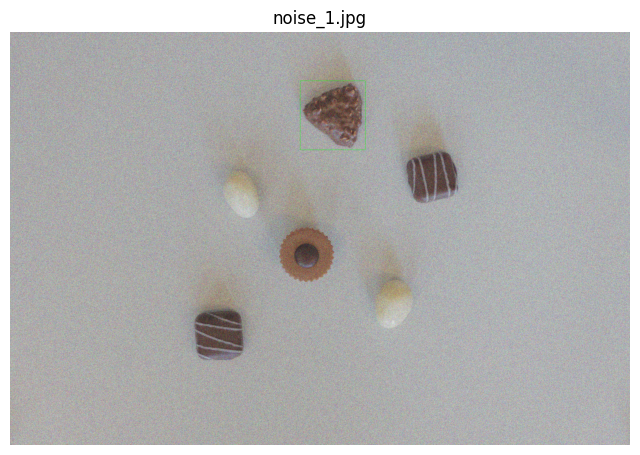

In [135]:
def add_noise(img_class, noise_const=15, return_image=False, img=None, save_dir=Generated_img_path):
    """
    Adds Gaussian noise to an image.

    Args:
        img_class (AnnotatedImage): Input annotated image object.
        noise_const (float): Std deviation of the Gaussian noise.
        return_image (bool): If True, return (noisy_img, AnnotatedImage) without saving.
        img (np.ndarray): Optional in-memory image to apply noise on. If None, loads from disk.
        save_dir (str): Directory where to save the image (if not returning).

    Returns:
        Tuple[np.ndarray, AnnotatedImage] if return_image else AnnotatedImage
    """
    if img is None:
        img_path = img_class.image_path
        if not os.path.isabs(img_path):
            img_path = os.path.join(DS_path, img_path)

        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

    if img.dtype != np.uint8:
        raise ValueError("Input image must be of type uint8.")

    # Apply noise
    img_float = img.astype(np.float32)
    noise = np.random.normal(0, noise_const, img.shape).astype(np.float32)
    noisy_img = np.clip(img_float + noise, 0, 255).astype(np.uint8)

    # Prepare updated annotation
    updated_img = AnnotatedImage(
        image_path=img_class.image_path,
        bboxes=img_class.bboxes,
        labels=img_class.labels,
        width=img_class.width,
        height=img_class.height
    )

    if return_image:
        return noisy_img, updated_img

    # Save
    os.makedirs(save_dir, exist_ok=True)
    existing = [f for f in os.listdir(save_dir) if f.startswith("noise_") and f.endswith(".jpg")]
    next_index = 1 + max([int(f.split("_")[1].split(".")[0]) for f in existing] or [0])
    filename = f"noise_{next_index}.jpg"
    filepath = os.path.join(save_dir, filename)
    cv2.imwrite(filepath, noisy_img)

    updated_img.image_path = filename
    return updated_img

noisy_img_class = add_noise(img, noise_const=100)
show_image_with_boxes(noisy_img_class)

### Rotations

In [126]:
def denormalize_box(box, img_w, img_h):
    """Convert normalized box to pixel-space [x_min, y_min, x_max, y_max]."""
    cx, cy, w, h = box
    x_min = int((cx - w / 2) * img_w)
    y_min = int((cy - h / 2) * img_h)
    x_max = int((cx + w / 2) * img_w)
    y_max = int((cy + h / 2) * img_h)
    return [x_min, y_min, x_max, y_max]

def normalize_box(box, img_w, img_h):
    """Convert pixel-space [x_min, y_min, x_max, y_max] to normalized center format."""
    x_min, y_min, x_max, y_max = box
    cx = ((x_min + x_max) / 2) / img_w
    cy = ((y_min + y_max) / 2) / img_h
    w = (x_max - x_min) / img_w
    h = (y_max - y_min) / img_h
    return [cx, cy, w, h]

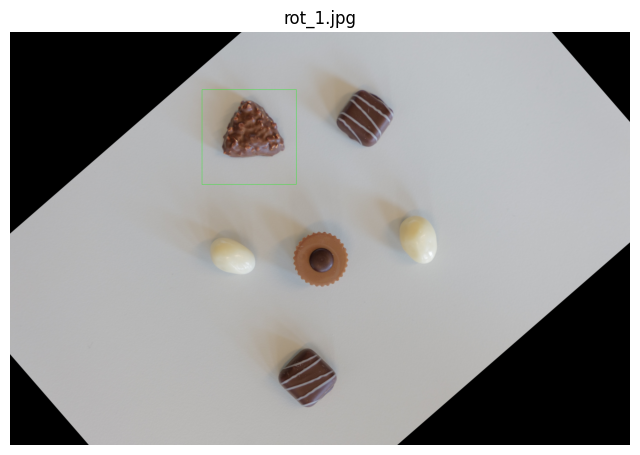

In [136]:
def rotate_image_and_boxes(img_class, angle, return_image=False, img=None, save_dir=Generated_img_path):
    """
    Rotates an image and its normalized bounding boxes.

    Args:
        img_class (AnnotatedImage): The input image and annotations.
        angle (float): Rotation angle in degrees (positive = counter-clockwise).
        return_image (bool): If True, returns (image, annotated_object) without saving.
        img (np.ndarray or None): Optional in-memory image to rotate.
        save_dir (str): Directory to save the rotated image if saving.

    Returns:
        Tuple[np.ndarray, AnnotatedImage] if return_image=True, else AnnotatedImage
    """
    # Load image if not provided
    if img is None:
        img_path = img_class.image_path
        if not os.path.isabs(img_path):
            img_path = os.path.join(DS_path, img_path)

        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

    h, w = img_class.height, img_class.width
    center = (w // 2, h // 2)

    # Rotate image
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale=1.0)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR)

    # Update bounding boxes
    new_boxes = []
    for box in img_class.bboxes:
        x_min, y_min, x_max, y_max = denormalize_box(box, w, h)
        corners = np.array([
            [x_min, y_min],
            [x_max, y_min],
            [x_max, y_max],
            [x_min, y_max]
        ])
        corners_hom = np.hstack([corners, np.ones((4, 1))])  # add homogeneous coord
        rotated_corners = (rotation_matrix @ corners_hom.T).T
        x_coords, y_coords = rotated_corners[:, 0], rotated_corners[:, 1]

        x_min_r, x_max_r = max(0, x_coords.min()), min(w, x_coords.max())
        y_min_r, y_max_r = max(0, y_coords.min()), min(h, y_coords.max())
        new_box = normalize_box([x_min_r, y_min_r, x_max_r, y_max_r], w, h)
        new_boxes.append(new_box)

    updated = AnnotatedImage(
        image_path=img_class.image_path,
        bboxes=new_boxes,
        labels=img_class.labels,
        width=w,
        height=h
    )

    if return_image:
        return rotated_img, updated

    # Save image
    os.makedirs(save_dir, exist_ok=True)
    existing = [f for f in os.listdir(save_dir) if f.startswith("rot_") and f.endswith(".jpg")]
    next_index = 1 + max([int(f.split("_")[1].split(".")[0]) for f in existing] or [0])
    filename = f"rot_{next_index}.jpg"
    filepath = os.path.join(save_dir, filename)
    cv2.imwrite(filepath, rotated_img)

    updated.image_path = filename
    return updated

rot =rotate_image_and_boxes(img, 41)

show_image_with_boxes(rot)

#/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/L1000756.JPG

### Translation

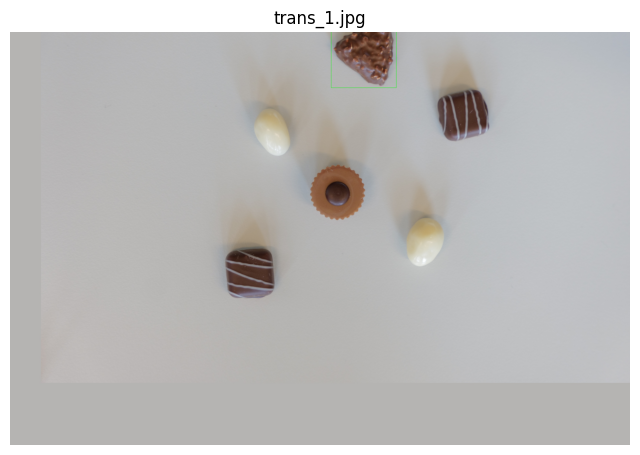

In [137]:
def translate_image_and_boxes(img_class, x_shift, y_shift, return_image=False, img=None, save_dir=Generated_img_path):
    """
    Translates an image and updates its YOLO-format bounding boxes.

    Args:
        img_class (AnnotatedImage): The image and its annotations.
        x_shift (int): Horizontal translation in pixels (positive = right).
        y_shift (int): Vertical translation in pixels (positive = down).
        return_image (bool): If True, return (image, AnnotatedImage) without saving.
        img (np.ndarray or None): Optional in-memory image.
        save_dir (str): Folder to save the translated image if return_image=False.

    Returns:
        Tuple[np.ndarray, AnnotatedImage] if return_image, else AnnotatedImage
    """
    # Load image if not provided
    if img is None:
        img_path = img_class.image_path
        if not os.path.isabs(img_path):
            img_path = os.path.join(DS_path, img_path)
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

    h, w = img_class.height, img_class.width

    # Compute mean color
    mean_color = tuple(map(int, img.mean(axis=(0, 1))))

    # Translation matrix
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    translated_img = cv2.warpAffine(img, M, (w, h), borderValue=mean_color)

    # Update bounding boxes
    new_bboxes = []
    new_labels = []
    for box, label in zip(img_class.bboxes, img_class.labels):
        cx, cy, bw, bh = box
        new_cx = (cx * w + x_shift) / w
        new_cy = (cy * h + y_shift) / h

        # Calculate visible portion
        threshold = 0.75
        x_left = new_cx - bw / 2
        x_right = new_cx + bw / 2
        y_top = new_cy - bh / 2
        y_bottom = new_cy + bh / 2

        visible_x = max(0, min(x_right, 1) - max(x_left, 0))
        visible_y = max(0, min(y_bottom, 1) - max(y_top, 0))
        visible_area = visible_x * visible_y
        total_area = bw * bh

        if total_area > 0 and (visible_area / total_area) >= threshold:
            new_bboxes.append([new_cx, new_cy, bw, bh])
            new_labels.append(label)

    updated = AnnotatedImage(
        image_path=img_class.image_path,
        bboxes=new_bboxes,
        labels=new_labels,
        width=w,
        height=h
    )

    if return_image:
        return translated_img, updated

    # Save to file
    os.makedirs(save_dir, exist_ok=True)
    existing = [f for f in os.listdir(save_dir) if f.startswith("trans_") and f.endswith(".jpg")]
    next_index = 1 + max([int(f.split("_")[1].split(".")[0]) for f in existing] or [0])
    filename = f"trans_{next_index}.jpg"
    filepath = os.path.join(save_dir, filename)
    cv2.imwrite(filepath, translated_img)

    updated.image_path = filename
    return updated

translated = translate_image_and_boxes(img, x_shift=300, y_shift=-600, save_dir=Generated_img_path)
show_image_with_boxes(translated)

### Horizontal and vertical flips

In [138]:
def flip_image_and_boxes(img_class, horizontal=True, vertical=False,
                         return_image=False, img=None, save_dir=Generated_img_path):
    """
    Flips an image and updates YOLO-format bounding boxes accordingly.

    Args:
        img_class (AnnotatedImage): The input image and annotations.
        horizontal (bool): Apply horizontal flip.
        vertical (bool): Apply vertical flip.
        return_image (bool): If True, return (image, AnnotatedImage) without saving.
        img (np.ndarray or None): Optional in-memory image to flip.
        save_dir (str): Directory to save flipped images if return_image is False.

    Returns:
        Tuple[np.ndarray, AnnotatedImage] if return_image is True, else AnnotatedImage
    """
    assert horizontal or vertical, "At least one flip direction must be True."

    # Load image if not provided
    if img is None:
        img_path = img_class.image_path
        if not os.path.isabs(img_path):
            img_path = os.path.join(DS_path, img_path)

        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

    h, w = img_class.height, img_class.width

    # Determine flip code for OpenCV
    if horizontal and vertical:
        flip_code = -1
    elif horizontal:
        flip_code = 1
    elif vertical:
        flip_code = 0

    flipped_img = cv2.flip(img, flipCode=flip_code)

    # Update bounding boxes
    new_bboxes = []
    for cx, cy, bw, bh in img_class.bboxes:
        if horizontal:
            cx = 1.0 - cx
        if vertical:
            cy = 1.0 - cy
        new_bboxes.append([cx, cy, bw, bh])

    updated = AnnotatedImage(
        image_path=img_class.image_path,
        bboxes=new_bboxes,
        labels=img_class.labels,
        width=w,
        height=h
    )

    if return_image:
        return flipped_img, updated

    # Save to file
    os.makedirs(save_dir, exist_ok=True)
    prefix = "flip_hv" if horizontal and vertical else "flip_h" if horizontal else "flip_v"
    existing = [f for f in os.listdir(save_dir) if f.startswith(prefix) and f.endswith(".jpg")]
    next_index = 1 + max([int(f.split("_")[-1].split(".")[0]) for f in existing] or [0])
    filename = f"{prefix}_{next_index}.jpg"
    filepath = os.path.join(save_dir, filename)
    cv2.imwrite(filepath, flipped_img)

    updated.image_path = filename
    return updated

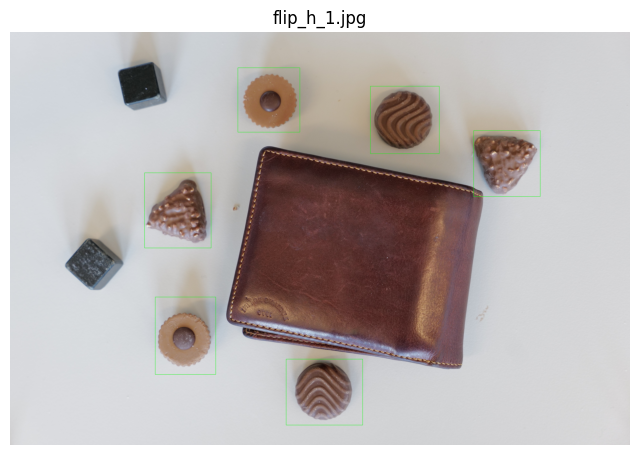

In [139]:
flipped=flip_image_and_boxes(annotated_images[6])
show_image_with_boxes(flipped)

### Cut-off in img

In [140]:
def cutout_image_and_boxes(img_class, erase_ratio_range=(0.1, 0.2), random_color=False,
                           return_image=False, img=None, save_dir=Generated_img_path):
    """
    Applies random cutout (erasing) on the image, and returns updated AnnotatedImage.

    Args:
        img_class (AnnotatedImage): The image + YOLO-format bboxes.
        erase_ratio_range (tuple): Min/max ratio of erased area (e.g. 10–20%).
        random_color (bool): If True, fill with random color. Else, fill with mean color.
        return_image (bool): If True, return (img, AnnotatedImage) without saving.
        img (np.ndarray or None): Optional in-memory image to apply cutout to.
        save_dir (str): Folder to save the cutout image (used only if return_image=False).

    Returns:
        Tuple[np.ndarray, AnnotatedImage] if return_image else AnnotatedImage
    """
    # Load image if not provided
    if img is None:
        img_path = img_class.image_path
        if not os.path.isabs(img_path):
            img_path = os.path.join(DS_path, img_path)

        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

    h, w = img_class.height, img_class.width

    # Erase area
    erase_area = random.uniform(*erase_ratio_range) * w * h
    aspect_ratio = random.uniform(0.5, 2.0)
    erase_h = int(np.sqrt(erase_area / aspect_ratio))
    erase_w = int(np.sqrt(erase_area * aspect_ratio))

    # Random position (top-left)
    x_min = random.randint(0, max(1, w - erase_w))
    y_min = random.randint(0, max(1, h - erase_h))
    x_max = x_min + erase_w
    y_max = y_min + erase_h

    # Fill value
    fill_color = (
        [random.randint(0, 255) for _ in range(3)] if random_color
        else tuple(map(int, img.mean(axis=(0, 1))))
    )

    # Apply cutout
    img[y_min:y_max, x_min:x_max] = fill_color

    # Filter boxes by visible area
    new_bboxes = []
    new_labels = []
    threshold = 0.6  # keep only if 60% or more is visible

    for box, label in zip(img_class.bboxes, img_class.labels):
        cx, cy, bw, bh = box
        box_x = cx * w
        box_y = cy * h
        box_w = bw * w
        box_h = bh * h

        box_left = box_x - box_w / 2
        box_right = box_x + box_w / 2
        box_top = box_y - box_h / 2
        box_bottom = box_y + box_h / 2

        # Calculate overlap with cutout
        inter_left = max(box_left, x_min)
        inter_right = min(box_right, x_max)
        inter_top = max(box_top, y_min)
        inter_bottom = min(box_bottom, y_max)

        inter_w = max(0, inter_right - inter_left)
        inter_h = max(0, inter_bottom - inter_top)
        inter_area = inter_w * inter_h

        box_area = box_w * box_h
        visible_area = box_area - inter_area

        if visible_area / box_area >= threshold:
            new_bboxes.append(box)
            new_labels.append(label)

    updated = AnnotatedImage(
        image_path=img_class.image_path,
        bboxes=new_bboxes,
        labels=new_labels,
        width=w,
        height=h
    )

    if return_image:
        return img, updated

    # Save image
    os.makedirs(save_dir, exist_ok=True)
    existing = [f for f in os.listdir(save_dir) if f.startswith("cutout_") and f.endswith(".jpg")]
    next_index = 1 + max([int(f.split("_")[1].split(".")[0]) for f in existing] or [0])
    filename = f"cutout_{next_index}.jpg"
    filepath = os.path.join(save_dir, filename)
    cv2.imwrite(filepath, img)

    updated.image_path = filename
    return updated

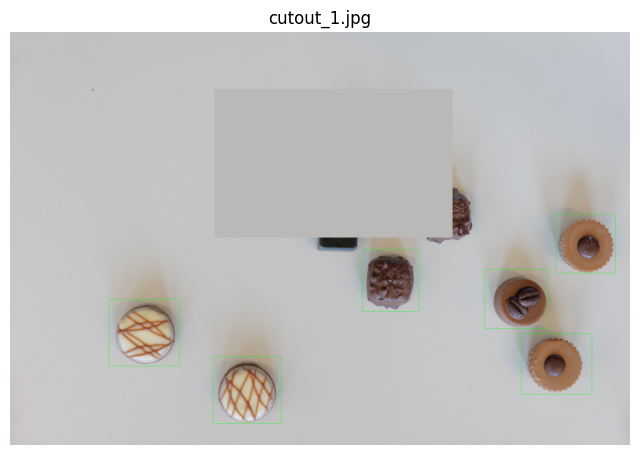

In [141]:
cutoff = cutout_image_and_boxes(annotated_images[30])
show_image_with_boxes(cutoff)

## FINAL AUGMENTATION IMPLEMENTED

In [144]:
def save_augmented_image(image, annotated_obj, prefix, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    existing = [f for f in os.listdir(save_dir) if f.startswith(prefix) and f.endswith(".jpg")]
    next_index = 1 + max([int(f.split("_")[-1].split(".")[0]) for f in existing] or [0])
    filename = f"{prefix}_{next_index}.jpg"
    filepath = os.path.join(save_dir, filename)

    cv2.imwrite(filepath, image)

    # Update path
    annotated_obj.image_path = filename
    return annotated_obj

def augment_and_export_dataset(
    images,
    num_augments_per_image=3,
    save_dir=DS_path,
    output_json="augmented_annotations.json",
    nr_times_per_image=1
):
    """
    Applies random combinations of augmentations and saves a new JSON dataset.

    Args:
        images (List[AnnotatedImage]): Original annotated images.
        num_augments_per_image (int): How many augmented variants to generate per image.
        save_dir (str): Folder to save new images.
        output_json (str): Path to save the JSON file.

    Returns:
        List[AnnotatedImage]: All new augmented image objects.
    """
    os.makedirs(save_dir, exist_ok=True)
    all_augmented = []

    for _ in range(nr_times_per_image):
        for img in images:
            for _ in range(num_augments_per_image):
                aug_img = img

                # Load image
                img_path = aug_img.image_path
                if not os.path.isabs(img_path):
                    img_path = os.path.join(DS_path, img_path)
                img_np = cv2.imread(img_path)

                if img_np is None:
                    print(f"❌ Skipping image (not found): {img_path}")
                    continue

                # Apply augmentations (properly chained)
                if random.random() < 0.5:
                    img_np, aug_img = rotate_image_and_boxes(
                        aug_img, angle=random.choice([-15, 15, -30, 30, -45, 45]),
                        return_image=True, img=img_np)

                if random.random() < 0.5:
                    img_np, aug_img = translate_image_and_boxes(
                        aug_img, x_shift=random.randint(-300, 300), y_shift=random.randint(-400, 400),
                        return_image=True, img=img_np)

                if random.random() < 0.5:
                    if random.random() < 0.5:
                        horizontal, vertical = True, random.choice([False, True])
                    else:
                        horizontal, vertical = random.choice([False, True]), True
                    img_np, aug_img = flip_image_and_boxes(
                        aug_img, horizontal=horizontal, vertical=vertical,
                        return_image=True, img=img_np)

                if random.random() < 0.5:
                    img_np, aug_img = add_noise(
                        aug_img, noise_const=random.randint(50, 100),
                        return_image=True, img=img_np)

                if random.random() < 0.5:
                    img_np, aug_img = cutout_image_and_boxes(
                        aug_img, return_image=True, img=img_np)

                # Save final image + annotation
                final = save_augmented_image(img_np, aug_img, prefix="aug", save_dir=save_dir)
                all_augmented.append(final)

    # Write JSON
    output_data = [{
        "image_id": img.image_path,
        "bboxes": img.bboxes,
        "labels": img.labels,
        "width": img.width,
        "height": img.height
    } for img in all_augmented]

    with open(output_json, "w") as f:
        json.dump(output_data, f, indent=2)

    print(f"✅ Generated {len(all_augmented)} augmented images.")
    print(f"📁 Images saved in: {save_dir}")
    print(f"📝 JSON saved to: {output_json}")

    return all_augmented

In [145]:
augment_and_export_dataset(annotated_images)

❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_10.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_10.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_10.jpg


[ WARN:0@8069.442] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_10.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8069.443] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_10.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8069.444] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_10.jpg'): can't open/read file: check file path/integrity


❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_56.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_56.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_56.jpg


[ WARN:0@8143.107] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_56.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8143.109] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_56.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8143.109] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_56.jpg'): can't open/read file: check file path/integrity


❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_110.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_110.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_110.jpg


[ WARN:0@8223.934] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_110.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8223.936] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_110.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8223.936] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_110.jpg'): can't open/read file: check file path/integrity


❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_126.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_126.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_126.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_127.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_127.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition

[ WARN:0@8247.895] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_126.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8247.896] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_126.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8247.897] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_126.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8247.897] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_127.jpg'): can't open/r

❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_143.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_143.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_143.jpg


[ WARN:0@8263.400] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_143.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8263.402] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_143.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8263.402] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_143.jpg'): can't open/read file: check file path/integrity


❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_174.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_174.jpg
❌ Skipping image (not found): /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_174.jpg


[ WARN:0@8316.654] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_174.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8316.655] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_174.jpg'): can't open/read file: check file path/integrity
[ WARN:0@8316.656] global loadsave.cpp:268 findDecoder imread_('/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train/aug_174.jpg'): can't open/read file: check file path/integrity


✅ Generated 249 augmented images.
📁 Images saved in: /Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/dataset_project_iapr2025/train
📝 JSON saved to: augmented_annotations.json


[AnnotatedImage(file='aug_1.jpg', boxes=[[0.239259, 0.5851850000000001, 0.096296, 0.162963], [0.22259300000000004, 0.30925899999999995, 0.109877, 0.159259]], labels = [7, 7]),
 AnnotatedImage(file='aug_2.jpg', boxes=[[np.float64(0.3832656174280553), np.float64(0.5612848224071868), np.float64(0.14237006000619642), np.float64(0.2088882661110431)], [np.float64(0.4685795556433368), np.float64(0.3913827090331971), np.float64(0.14493106424016053), np.float64(0.21529195028848017)]], labels = [1, 1]),
 AnnotatedImage(file='aug_3.jpg', boxes=[[np.float64(0.4058488426693554), np.float64(0.3496989946788034), np.float64(0.1370608644199925), np.float64(0.20559129662998868)], [np.float64(0.3538764942521442), np.float64(0.6083232998977831), np.float64(0.1519101068249099), np.float64(0.227865160237365)], [np.float64(0.4555820196128093), np.float64(0.7424968116279306), np.float64(0.1457818480546266), np.float64(0.2186727720819398)], [np.float64(0.5429097070893479), np.float64(0.5749125044867187), np.fl

In [150]:
annotated_images=create_annotated_images_from_json("/Users/jarlstephansson/Desktop/EPFL/EE-451 Image analysis/Project/image_analysis_pattern_recognition/project/augmented_annotations.json")


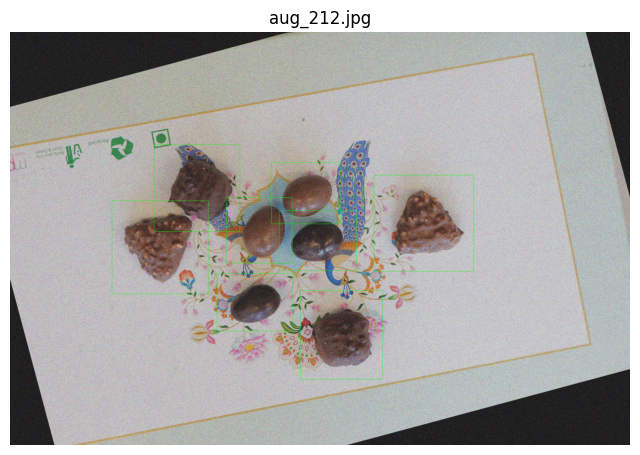

In [154]:
show_image_with_boxes(annotated_images[211])